In [1]:
########## Import ##########

import os
from simplified_scrapy import SimplifiedDoc, utils
import pandas as pd

import traci
import sumolib
from tqdm import tqdm
import random
import time
import matplotlib.pyplot as plt

import CH
import PredictPos
import ModifyFile

In [2]:
########## Initialisation ##########

listTime = []
listNbVeh = []
listTotLenVeh = []

f_memory = open("memorybasics.csv", "w")
f_memory.write('Information,x,y' + "\n")
f_memory.close()

f_time = open("time.csv", "w")
f_time.write('Nb car,time' + "\n")
f_time.close()

f_rsu = open("rsu.csv", "w")
f_rsu.write('time,vehicle,previous,future' + "\n")
f_rsu.close()

f_CH = open("CH.csv", "w")
f_CH.write('lenVeh,CH,CHbck,CM' + "\n")
f_CH.close()

sumoBinary = "/Users/remi/sumo/bin/sumo-gui"
sumoCmd = [sumoBinary,'-c','data/one_run/m/osm.sumocfg','-n', 'data/one_run/m/osm.net.xml']

time_start = time.time()
traci.start(sumoCmd)

########## Position of Traffic Light ##########

net = sumolib.net.readNet('data/one_run/m/osm.net.xml')

node_ids = [node.getID() for node in net.getNodes()]
traffic_pos = []
traffic_index = []
i = 0

for node in node_ids:
    if (net.getNode(node).getType()) == 'traffic_light':
        traffic_pos.append(net.getNode(node).getCoord())
        traffic_index.append(i)
        i = i + 1

########## Selection of the lanes and edges ##########

TotalLane = traci.lane.getIDList()
TotalListLane = list(TotalLane)
ListRemove = []

TotalEdge = traci.edge.getIDList()
TotalBigEdge = list(TotalEdge)

for edge in TotalEdge:
    if(traci.edge.getLaneNumber(edge) < 2):
        TotalBigEdge.remove(edge)

allCar = []

for edge in TotalBigEdge:
    for lane in TotalLane:
        if(lane[0:10] in edge):
            if lane in TotalListLane:
                TotalListLane.remove(lane)

TotalLane = tuple(TotalListLane)

TotalLane = tuple(TotalListLane)
for lane in TotalLane:
    if(traci.lane.getMaxSpeed(lane)< 8.3):   #8.34 = 30 km/h
        TotalListLane.remove(lane)

########## Some informations ##########

print('number of traffic lighters: ', len(traffic_pos))
print('edge before: ', len(TotalEdge), 'edge after: ', len(TotalBigEdge))
print('lane before: ', len(TotalLane), 'lane after: ', len(TotalListLane))

 Retrying in 1 seconds
number of traffic lighters:  6
edge before:  3312 edge after:  82
lane before:  2729 lane after:  365


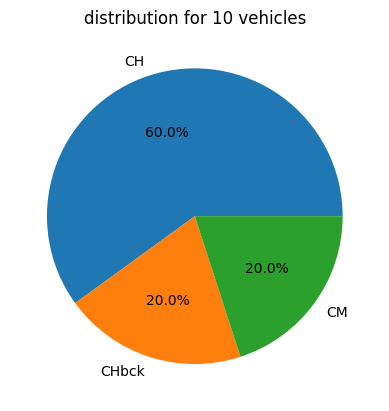

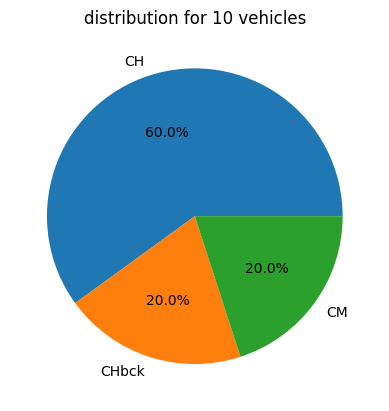

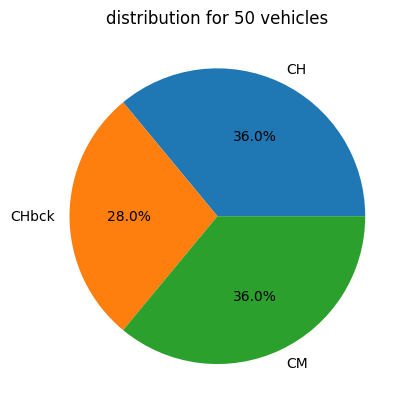

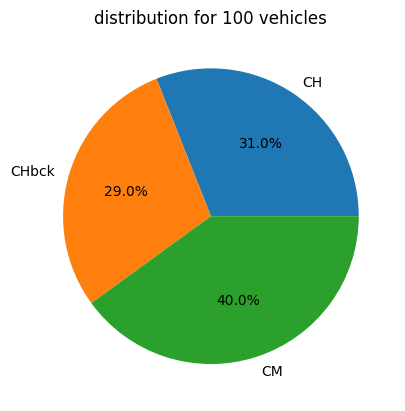

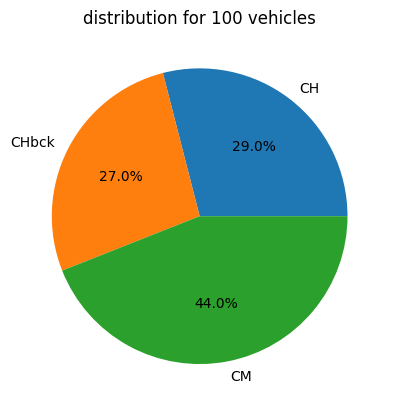

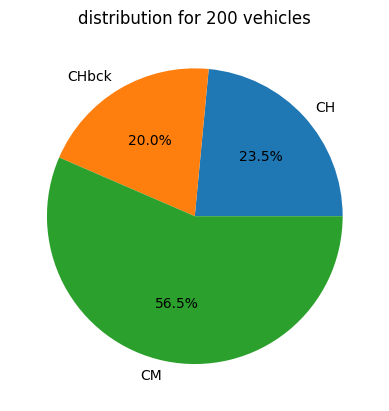

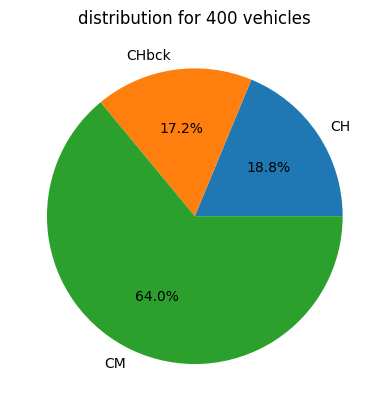

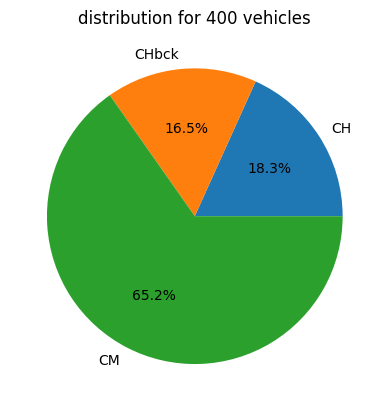

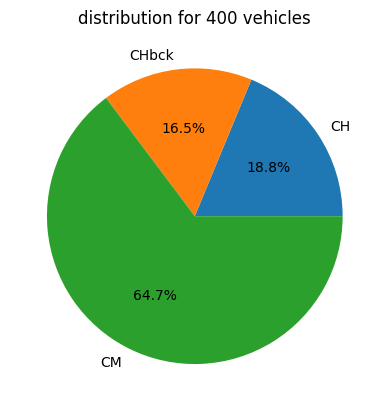

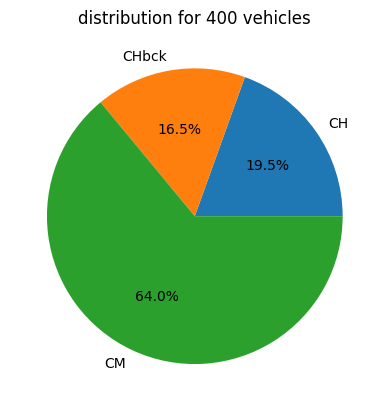

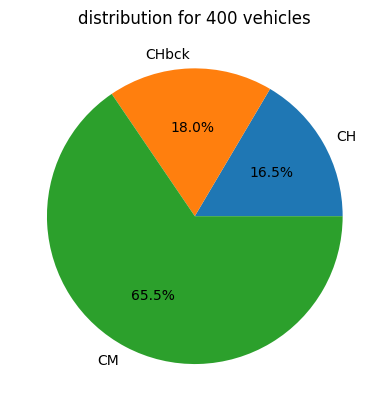

KeyboardInterrupt: 

In [3]:
########## Launch of the simulation ##########

count = 2000 #960240
i = 0
while traci.simulation.getTime() <= count:

########## Simulation Step ##########

    traci.simulationStep()
    current_time = traci.simulation.getTime()

    action= i%9

########## List Vehicle ##########

    listVehID = []

    for edge in TotalBigEdge:
        listVeh = traci.edge.getLastStepVehicleIDs(edge)
        listVehID = listVehID + list(listVeh)
    for lane in TotalListLane:
        listVeh = traci.lane.getLastStepVehicleIDs(lane)
        listVehID = listVehID + list(listVeh)
    
    listVehID.sort()
    listVehID = list(set(listVehID))

    lenListVeh = len(listVehID)

########## CH ##########

    if i == 10:
        listNeighbor = CH.detectNeighbourg(listVehID)
        [listRole, listIDassigned, listRank]= CH.roleCar(listVehID,listNeighbor)
        qty = CH.assignColor(listIDassigned, listRole)
    if i > 10:
        time0 = time.time()
        listNeighbor = CH.detectNeighbourg(listVehID)
        [ListRole, listIDassigned, ListRank] = CH.maintainCH(listVehID, listIDassigned, listRank, listRole, listNeighbor)
        time1 = time.time()
        qty = CH.assignColor(listIDassigned, listRole)

        listTotLenVeh.append(lenListVeh)

        if lenListVeh == 10:
            ModifyFile.graphCHpie(qty,lenListVeh)
        elif lenListVeh == 50:
            ModifyFile.graphCHpie(qty,lenListVeh)
        elif lenListVeh == 100:
            ModifyFile.graphCHpie(qty,lenListVeh)
        elif lenListVeh == 200:
            ModifyFile.graphCHpie(qty,lenListVeh)
        elif lenListVeh == 400:
            ModifyFile.graphCHpie(qty,lenListVeh)
        elif lenListVeh == 800:
            ModifyFile.graphCHpie(qty,lenListVeh)

        f_CH = open("CH.csv", "a")
        f_CH.write(str(lenListVeh)+","+str(qty[0]) + "," + str(qty[1]) +","+ str(qty[2]) + "\n")
        f_CH.close

        f_time = open("time.csv", "a")
        f_duration = time1 - time0
        f_time.write(str(lenListVeh) + "," + str(f_duration) + "\n")
        f_time.close

########## Prediction position ##########

    timeSimu = traci.simulation.getTime()
    memory_time = '\ntime: %d \n' %timeSimu
    f_memory = open("memorybasics.csv", "a")
    f_memory.write(memory_time + "\n")

    f_rsu = open("rsu.csv", "a")
    RSU_time = '%d,' %timeSimu

    for vehicle in listVehID:
        if vehicle in allCar:
            pass
        else:
            allCar.append(vehicle)

        # Position
        position = traci.vehicle.getPosition(vehicle)
        futurPos = PredictPos.FuturPos(vehicle)
        memory_vehi = 'vehicle: %s' %vehicle
        memory_pos = 'Current Position:, %f,%f' %(position[0],position[1])
        memory_fut = 'Predict Position:, %f,%f' %(futurPos[0],futurPos[1])
        f_memory.write(memory_vehi + "\n" + memory_pos + "\n" + memory_fut + "\n")

        # RSU
        informationRSU = PredictPos.InformedCar(vehicle, traffic_pos)
        RSU_veh = '%s,' %vehicle
        RSU_previous = '%s,' %str(informationRSU[1])
        RSU_futur = '%s,' %str(informationRSU[0])
        f_rsu.write(RSU_time + RSU_veh + RSU_previous + RSU_futur+'\n')

    f_memory.close()
    f_rsu.close()

    i = i + 1 

########## End simulation ##########

time_end = time.time()
print ("traci time elapsed: {}".format(time_end-time_start))

In [ ]:
########## Analyse ##########

print(allCar)

ModifyFile.traceCurve()

for vehicle in allCar:
    ModifyFile.calculationError(vehicle)

ModifyFile.calculationTot()

traci.close(True)